In [16]:
# imports
# !pip install torch 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import datetime 

In [17]:
def displayDataFrame(df_to_display, all_frame=False):
    if all_frame:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(df_to_display)
    else:
        display(df_to_display)

In [18]:
# read data
area_codes_df = pd.read_excel('/Users/e.vargas/Desktop/Lead Routing/areacodes.xlsx', header=None)
displayDataFrame(area_codes_df, all_frame=False)

leads_df = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/all_calls_2021.csv', 
                    parse_dates=['callDate','callStartTime'])
displayDataFrame(leads_df, all_frame=False)

leads_source_map = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/inhousesources.csv')
displayDataFrame(leads_source_map, all_frame=False)

leads_source_map2 = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/othersources.csv')
displayDataFrame(leads_source_map, all_frame=False)

0
0    201 NJ
1    202 DC
2    203 CT
3    204 MB
4    205 AL
..      ...
345  979 TX
346  980 NC
347  984 NC
348  985 LA
349  989 MI

[350 rows x 1 columns]

isSale agentId supervisorId     site shiftStartTime  atOffice  \
0             0     0K4         JS01      USE       09:45 AM         0   
1             0     H3V          DH1  CLW-RET            NaN         0   
2             1     GW5          CF1      BKV       09:45 AM         1   
3             0     GWF          AB1      BKV       09:45 AM         0   
4             0     P14          0BO      NBF       09:45 AM         0   
...         ...     ...          ...      ...            ...       ...   
1692991       0     0AJ          VB1      FLL       07:45 AM         0   
1692992       0     0AJ          VB1      FLL       07:45 AM         0   
1692993       0     0AJ          VB1      FLL       07:45 AM         0   
1692994       0     0M2          RM2      USE       09:45 AM         0   
1692995       0     A14          VB1      FLL       07:45 AM         0   

         tenure       callStartTime areaCode   callDate        DNIS  callCount  
0           3.0 2021-08-11 15:34:35      561 2021-06-11  7273258496          1  
1          59.0 2021-08-11 14:17:30      561 2021-05-26  8552260441          1  
2          61.0 2021-08-11 15:29:56      229 2021-07-09  7273258512          1  
3          61.0 2021-08-11 13:19:06      863 2021-01-18  8558887732          1  
4          13.0 2021-08-11 15:42:29      209 2021-01-07  8553282892          2  
...         ...                 ...      ...        ...         ...        ...  
1692991     5.0 2021-08-11 13:48:52      206 2021-08-09  8558046073          1  
1692992     5.0 2021-08-11 13:48:52      206 2021-08-09  8558046073          1  
1692993     5.0 2021-08-11 13:48:52      206 2021-08-09  8558046073          1  
1692994     2.0 2021-08-11 13:46:05      843 2021-08-09  7272505737          1  
1692995    49.0 2021-08-11 13:57:07      617 2021-08-09  8558052078          1  

[1692996 rows x 12 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

In [19]:
# temp cut down data
#leads_df = leads_df.sample(22000)

In [20]:
# build area osr3 dictionary
osr3s = {}
for index, row in leads_source_map.iterrows():
    osr3s[row['DNIS']] = row['Source']

for index, row in leads_source_map2.iterrows():
    osr3s[row['DNIS']] = row['Source']

In [21]:
# add osr3 column to leads df using DNIS
leads_df['osr3'] = leads_df['DNIS'].map(osr3s).fillna(leads_df['DNIS'])

In [22]:
# build area code dictionary
area_codes = {}
for r in area_codes_df[0]:
    area_codes[r.split()[0]] = r.split()[1]

In [23]:
# add state column to leads df using areacode
leads_df['state'] = leads_df['areaCode'].map(area_codes).fillna('NA')
# print(leads)

In [24]:
# add day of week column 
leads_df['dayOfWeek'] = leads_df['callDate'].dt.day_name()

In [25]:
# convert date to medicare season
def get_medicare_season(date):
    AEPStart = datetime.datetime.strptime("15-10-2020", "%d-%m-%Y").replace(year=date.year)
    AEPEnd = datetime.datetime.strptime("07-12-2020", "%d-%m-%Y").replace(year=date.year)
    OEPStart = datetime.datetime.strptime("01-01-2020", "%d-%m-%Y").replace(year=date.year)
    OEPEnd = datetime.datetime.strptime("31-03-2020", "%d-%m-%Y").replace(year=date.year)
    if AEPStart <= date <= AEPEnd:
        return 'AEP'
    elif OEPStart <= date <= OEPEnd:
        return 'OEP'
    else:
        return 'ROY'

In [26]:
# convert time to seconds of day
def get_seconds_of_day(timestamp):
    midnight = datetime.date(
        timestamp.year, timestamp.month, timestamp.day)
    return int(timestamp.strftime('%s')) - int(midnight.strftime('%s'))

In [27]:
# add medicare season column using callDate
leads_df['medicareSeason'] = leads_df['callDate'].apply(
                        lambda x: get_medicare_season(x))


# add seconds of day using callStartTime
leads_df['callStartTime'] = leads_df['callStartTime'].apply(
                        lambda x: get_seconds_of_day(x))

displayDataFrame(leads_df)

isSale agentId supervisorId site shiftStartTime  atOffice  tenure  \
896467        0     R90          VB1  FLL       07:45 AM         0    12.0   
1607371       0     T27          ME1  NBF       09:45 AM         0    12.0   
1441794       0     00D         JS01  SLC       10:45 AM         0     5.0   
1169348       0     Q88          0J2  SLC       07:45 AM         0    13.0   
1504412       0     K39          0BO  NBF       07:45 AM         0    23.0   
...         ...     ...          ...  ...            ...       ...     ...   
950326        0     GVG          0L5  CLW       09:45 AM         0    60.0   
1536108       0     0EA          0MB  SLC       07:45 AM         0     5.0   
698935        0     O91          VB1  FLL       09:45 AM         0    14.0   
17436         0     J45          D19  LHR            NaN         0    23.0   
1299578       0     01V          D68  FLL       07:45 AM         0     5.0   

         callStartTime areaCode   callDate        DNIS  callCount        osr3  \
896467           39280      929 2021-04-12     7726474          1     7726474   
1607371          68450      757 2021-07-22  7578915584          1  7578915584   
1441794          66139      956 2021-06-28  7273060365          1         QTM   
1169348          46520      812 2021-05-18  8552144394          1          IB   
1504412          65486      484 2021-07-14  4842491968          1  4842491968   
...                ...      ...        ...         ...        ...         ...   
950326           51645      860 2021-04-16  8558201722          2          IB   
1536108          49916      469 2021-07-23  4694159984          1  4694159984   
698935           38811      210 2021-03-19  7272950154          1         US4   
17436            53582      434 2021-06-22  8558913366          1  8558913366   
1299578          33474      682 2021-06-07  8558739085          1          IB   

        state  dayOfWeek medicareSeason  
896467     NA     Monday            ROY  
1607371    VA   Thursday            ROY  
1441794    TX     Monday            ROY  
1169348    IN    Tuesday            ROY  
1504412    PA  Wednesday            ROY  
...       ...        ...            ...  
950326     CT     Friday            ROY  
1536108    TX     Friday            ROY  
698935     TX     Friday            OEP  
17436      VA    Tuesday            ROY  
1299578    TX     Monday            ROY  

[22000 rows x 16 columns]

<AxesSubplot:xlabel='isSale', ylabel='count'>

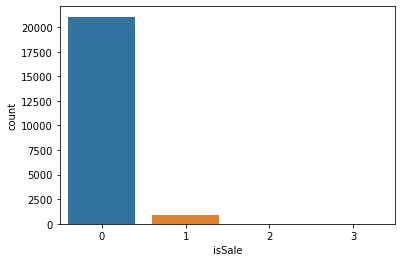

In [28]:
# visualize data
sns.countplot(x = 'isSale', data=leads_df)

In [44]:
# drop callDate and callCount
leads_df = leads_df.drop(columns=['callDate', 'callCount'])
leads_df = leads_df[['isSale', 'shiftStartTime', 'tenure', 'callStartTime', 'site', 'areaCode', 'DNIS', 'atOffice', 'osr3', 'state', 'dayOfWeek', 'medicareSeason', 'supervisorId', 'agentId']]

# get the dummy variables
leads_df = pd.get_dummies(leads_df, drop_first=True, columns=['agentId', 'areaCode','site','supervisorId','shiftStartTime', 'state', 'dayOfWeek', 'medicareSeason', 'osr3'])

displayDataFrame(leads_df) 

MultiLabelBinarizer()

In [42]:
# fill in nans
leads_df = leads_df.fillna(leads_df.mean())

# input and outputs
X = leads_df.iloc[:, 1:]
y = leads_df.iloc[:, 0]
print(X)

         atOffice  tenure  callStartTime        DNIS  agentId_00B  \
708345          0     1.0          60129  7272950703            0   
788732          0    17.0          67618  7273060365            0   
1381103         0     5.0          37363  3363965043            0   
695582          0    13.0          56772  8667600812            0   
1395831         0     4.0          43195  7273060365            0   
...           ...     ...            ...         ...          ...   
399812          0    29.0          41790  8556737412            0   
1071587         0    39.0          61098  7273060365            0   
1097774         0    23.0          29975  8553320982            0   
1135720         0    13.0          61206  7273060365            0   
186585          0    16.0          41091  3462224643            0   

         agentId_00C  agentId_00D  agentId_00E  agentId_00F  agentId_00G  ...  \
708345             0            0            0            0            0  ...   
788732   

In [43]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [44]:
# normalize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [45]:
# model parameters
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_SIZE = len(X_train[0])

In [46]:
## dataloader

# train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
# test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

In [47]:
# initialize dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [48]:
# binary classification model
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # 1073 inputs
        self.layer_1 = nn.Linear(INPUT_SIZE, 4*INPUT_SIZE) 
        self.layer_2 = nn.Linear(4*INPUT_SIZE, 4*INPUT_SIZE)
        self.layer_out = nn.Linear(4*INPUT_SIZE, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(4*INPUT_SIZE)
        self.batchnorm2 = nn.BatchNorm1d(4*INPUT_SIZE)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [49]:
# check if on gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [50]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [51]:
# initialize model and move to gpu
model = binaryClassification()
#model.to(device)
print(model)
pos_weight = torch.tensor([28])
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=2963, out_features=11852, bias=True)
  (layer_2): Linear(in_features=11852, out_features=11852, bias=True)
  (layer_out): Linear(in_features=11852, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(11852, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(11852, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
tensor([28])


In [ ]:
# train model
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 2.85031 | Acc: 63.702
Epoch 002: | Loss: 1.52626 | Acc: 78.153
Epoch 003: | Loss: 1.20279 | Acc: 83.582
Epoch 004: | Loss: 1.25800 | Acc: 85.553
Epoch 005: | Loss: 0.74929 | Acc: 89.804
Epoch 006: | Loss: 0.61168 | Acc: 91.720
Epoch 007: | Loss: 0.67480 | Acc: 92.233


In [ ]:
# test model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = y_test_pred #torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
sale_av = 0
sale_c = 0
fail_av = 0
fail_c = 0

for i in range(len(y_pred_list)):
    if y_test[i] == 0:
        fail_av += y_pred_list[i]
        fail_c += 1
    else:
        sale_av += y_pred_list[i]
        sale_c += 1
    print(y_pred_list[i], y_test[i])
    
print(sale_av/sale_c, fail_av/fail_c)